In [ ]:
# Integrantes Equipo 1:
# - Juan
# - David
# - Alfonso
# - Irving
# - Raúl
# - Alejandro

In [ ]:
# Conjunto de datos: https://www.kaggle.com/datasets/kanchana1990/whatsapp-business-reviews-app-store
#
#
# Diccionario de datos:
#
# ID: Unique identifier for each review entry.
# Date: Timestamp of the review.
# UserName (Hashed): Anonymized username of the reviewer.
# UserUrl (Hashed): Anonymized URL of the user's review profile.
# Version: App version the review pertains to.
# Score: User-provided rating for the app.
# Title: Title of the review.
# Text: Body text of the review, providing detailed feedback.
# URL: URL of the review on the App Store (anonymized if containing personal identifiers).
# Country: The country from which the review was posted.

In [71]:
# Instalación dependencias nltk: vader_lexicon (para análisis de sentimientos) y stopwords (para limpieza de texto)
import nltk
nltk.download("vader_lexicon")
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
# Carga de datos
import pandas as pd
data = pd.read_csv('data/hashed_wab_reviews.csv')

In [73]:
# EDA (Analisis Exploratorio de Datos - Exploratory Data Analysis)

In [74]:
data.dtypes.to_frame()

,0
id,int64
date,object
userName,object
userUrl,object
version,object
score,int64
title,object
text,object
url,object
country,object


In [75]:
data.head(3)

,id,date,userName,userUrl,version,score,title,text,url,country,appId
0,10990027692,2024-02-28T13:15:16-07:00,a71209417cc69068db96287dcfa258e84a19b36c443521...,c6434d50f03dc3225343d08cb75b120e19dc21937007da...,24.4.78,1,Status sounds,No sound comes from status videos after I upda...,https://itunes.apple.com/au/review?id=13864129...,AU,1386412985
1,10939311897,2024-02-14T14:47:02-07:00,9f7302dde70e971b057aa14cec1d26479a9362da32e9ed...,55105d432b1d6c664523f5de2576a199f8ffa8d8c20e8a...,24.3.76,2,Calls,"Every time I’m on a phone call, it either cut ...",https://itunes.apple.com/au/review?id=13864129...,AU,1386412985
2,10932303253,2024-02-12T15:54:56-07:00,ee939200223a21c2bdea5d17ef0ae2d9a03acfbb914c73...,1c044d9599692ebd0d50f4fb8d886f622ee02c549d76f8...,24.3.76,4,Recommendations,I like being to have a separate account/app fo...,https://itunes.apple.com/au/review?id=13864129...,AU,1386412985


In [76]:
df = data.copy()

In [77]:
# Seleccionamos variables que usaremos
df = df[['version', 'score', 'title', 'text', 'country']]

In [78]:
# Missings
df.isnull().sum()

version    0
score      0
title      0
text       0
country    0
dtype: int64

In [79]:
(df.astype(str) == '').sum()

version    0
score      0
title      0
text       0
country    0
dtype: int64

In [80]:
# Las variables que nos serán de utilidad serán:
# Score: 

In [81]:
# Detección de idioma
from langdetect import detect
def detectar(texto):
  try:
    return detect(texto)
  except:
    return "unknown"

df["idioma_title"] = df["title"].apply(detectar)
df["idioma_texto"] = df["text"].apply(detectar)

In [82]:
df[["idioma_title", "idioma_texto"]]

,idioma_title,idioma_texto
0,en,en
1,ca,en
2,fr,en
3,en,en
4,en,en
...,...,...
1454,ar,ar
1455,af,en
1456,ar,ar
1457,es,es


In [83]:
# Reemplazamos todo lo que no sean caracteres ni números por espacios vacíos
df["title"] = (
    df["title"]
    .astype(str)
    .str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
)

df["text"] = (
    df["text"]
    .astype(str)
    .str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
)

In [84]:
# Limpieza de Texto
def limpieza_texto(df, col):
  df[col] = (
      df[col]
      .astype(str)
      .str.replace(r"[\n\r\t]", " ", regex=True) # Quitamos saltos de linea, tabuladores
      .str.replace(":", " ", regex=False) # Se remueve puntuación
      .str.replace(r"\s+", " ", regex=True) # Se remueve signos
      .str.strip() # Se quitan espacios extra
  )
  return df

In [85]:
df = limpieza_texto(df, "title")
df = limpieza_texto(df, "text")

In [86]:
# Removemos emojis
import emoji
def remover_emojis(text):
  if not isinstance(text, str):
    return text
  return emoji.replace_emoji(text, replace="")

In [87]:
df["text"] = df["text"].apply(remover_emojis)
df["title"] = df["title"].apply(remover_emojis)

In [88]:
# Filtramos únicamente títulos y textos en inglés
df = df[(df["idioma_texto"] == "en") & (df["idioma_title"] == "en")]

In [89]:
# Selección de variables objetivo
# Continua: Score - Valores de 1 a 5, se entenderán como variable continua
# Discreta (dicotómica):  Score categórica - 1 si el score tiene valores (4,5); 0 si tiene valores (1,2,3)

In [90]:
df['score_cat'] = (df['score']>=4)*1 # 1  para valores (4,5). 0 para valores (1,2,3)

In [91]:
# Distribución de variable objetivo categórica
df['score_cat'].value_counts() / df.shape[0]

score_cat
0    0.55571
1    0.44429
Name: count, dtype: float64

In [92]:
# Distribución de variable objetivo continua
df['score'].value_counts().sort_index() / df.shape[0]

score
1    0.366295
2    0.076602
3    0.112813
4    0.103064
5    0.341226
Name: count, dtype: float64

In [93]:
# Creación de variables

In [94]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [95]:
sia = SentimentIntensityAnalyzer()

In [96]:
# Creación de variables de sentimiento detectado ('Text')
df["text_sentiment_score"] = df["text"].apply(sia.polarity_scores)
df["title_sentiment_score"] = df["title"].apply(sia.polarity_scores)

In [97]:
scores_df = df["text_sentiment_score"].apply(pd.Series)
df = pd.concat([df, scores_df], axis=1)
del df['text_sentiment_score']

In [98]:
df = df.rename(columns={
    "neg":"neg_text",
    "neu":"neu_text",
    "pos":"pos_text",
    "compound":"compound_text"
})

In [99]:
# Categorías positivo, negativo y neutral
df["sentiment_text"] = "neutral"
df.loc[df["compound_text"] > 0.05, "sentiment_text"] = "positive"
df.loc[df["compound_text"] < -0.05, "sentiment_text"] = "negative"

In [100]:
df['sentiment_text'].value_counts()

sentiment_text
positive    354
negative    200
neutral     164
Name: count, dtype: int64

In [101]:
# Creación de variables de sentimiento detectado ('Title')
scores_df = df["title_sentiment_score"].apply(pd.Series)
df = pd.concat([df, scores_df], axis=1)
del df['title_sentiment_score']

In [102]:
df = df.rename(columns={
    "neg":"neg_title",
    "neu":"neu_title",
    "pos":"pos_title",
    "compound":"compound_title"
})

In [103]:
df["sentiment_title"] = "neutral"
df.loc[df["compound_title"] > 0.05,  "sentiment_title"] = "positive"
df.loc[df["compound_title"] < -0.05, "sentiment_title"] = "negative"

In [104]:
# Correlación entre sentimientos de título y texto del review
df[["compound_title","compound_text"]].corr()

,compound_title,compound_text
compound_title,1.000000,0.394894
compound_text,0.394894,1.000000


In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

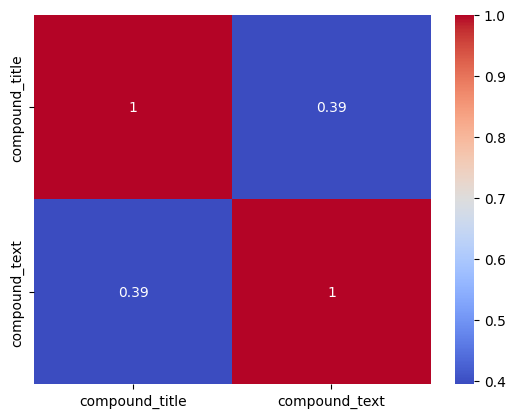

In [106]:
# Relación debil entre título y texto. Los titulos son poco informativos al ser muy cortos
sns.heatmap(
    df[["compound_title","compound_text"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.show()

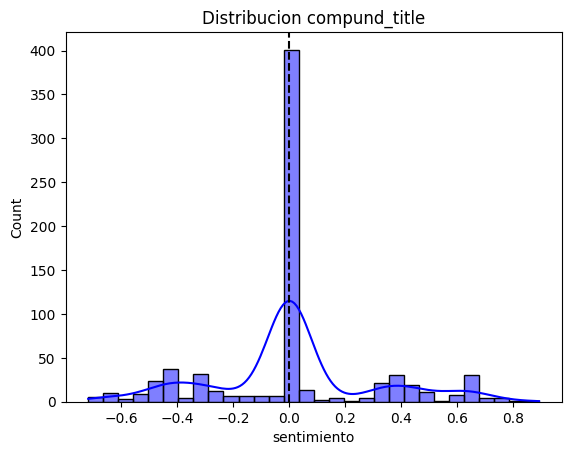

In [107]:
# La distribución del sentimiento del Título muestra una combinación de distribuciones para los valores negativos, otra para los positivos y otra para los neutros (crecanos a 0)
sns.histplot(
    df["compound_title"],
    bins=30,
    kde=True,
    color="blue"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribucion compund_title")
plt.xlabel("sentimiento")
plt.show()

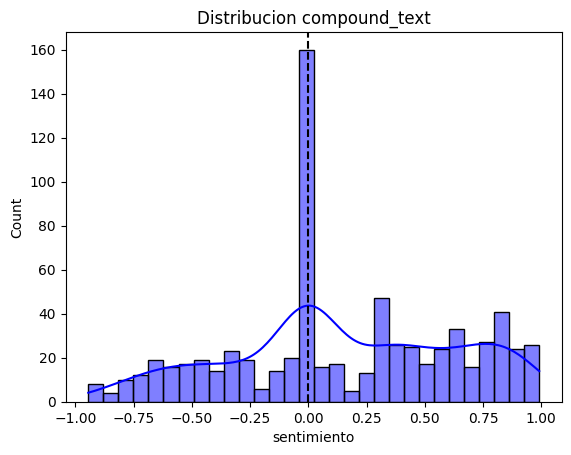

In [108]:
# El texto del review muestra una dsitribución menos cargada hacia el neutro
sns.histplot(
    df["compound_text"],
    bins=30,
    kde=True,
    color="blue"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribucion compound_text")
plt.xlabel("sentimiento")
plt.show()

In [109]:
# Variable de compound promedio
df["compound_avg"] = df[["compound_title","compound_text"]].mean(axis=1)

In [110]:
# El score y el compound tienen una correlación moderada
print("Correlacion entre score y compound_avg", df["score"].corr(df["compound_avg"]))

Correlacion entre score y compound_avg 0.5332340969950042


In [111]:
# Variables unarias
variables_unarias = df.nunique()[df.nunique()==1].index.tolist()
variables_unarias


['idioma_title', 'idioma_texto']

In [112]:
df.drop(columns = variables_unarias, inplace=True)

In [113]:
# Creación de variables dummies
categoricas_dummies = ['country', 'version', 'sentiment_text', 'sentiment_title']

In [114]:
def normalize(df, features):
    for feature in features:
        aux = df[feature].value_counts(True)
        ls_categories = [category for category, freq in aux.items() if freq > 0.05]
        df[feature] = df[feature].map(lambda x: x if x in ls_categories else "Others")
    return df

In [115]:
df = normalize(df, [x for x in categoricas_dummies])

In [116]:
def freq_discrete(df, features):
    """
    Calcula y muestra tablas de frecuencias absolutas, relativas y acumuladas para variables categóricas.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame que contiene las variables a analizar.
    features : list of str
        Lista con los nombres de las columnas categóricas a analizar.

    Descripción
    -----------
    Para cada variable en `features`, imprime su nombre y muestra una tabla con:
      - Frecuencia absoluta de cada categoría.
      - Frecuencia relativa (porcentaje) de cada categoría.
      - Frecuencia absoluta acumulada.
      - Frecuencia relativa acumulada.
    Los valores se formatean para mejor visualización.

    Ejemplo
    -------
    freq_discrete(df, ["color", "country"])
    """
    for feature in features:
        print(f"Feature: {feature}")
        abs_series = df[feature].value_counts(dropna=False)
        rel_series = df[feature].value_counts(dropna=False, normalize=True)
        freq = pd.DataFrame({"Absolute frequency": abs_series, "Relative frequency": rel_series})
        freq["Accumulated frequency"] = freq["Absolute frequency"].cumsum()
        freq["Accumulated %"] = freq["Relative frequency"].cumsum()
        freq["Absolute frequency"] = freq["Absolute frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Relative frequency"] = freq["Relative frequency"].map(lambda x: "{:,.2%}".format(x))
        freq["Accumulated frequency"] = freq["Accumulated frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Accumulated %"] = freq["Accumulated %"].map(lambda x: "{:,.2%}".format(x))
        display(freq)

In [117]:
freq_discrete(df, categoricas_dummies)

Feature: country


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
country,,,,
LK,322,44.85%,322,44.85%
US,206,28.69%,528,73.54%
CA,128,17.83%,656,91.36%
AU,62,8.64%,718,100.00%


Feature: version


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
version,,,,
Others,628,87.47%,628,87.47%
23.25.86,51,7.10%,679,94.57%
23.23.82,39,5.43%,718,100.00%


Feature: sentiment_text


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
sentiment_text,,,,
positive,354,49.30%,354,49.30%
negative,200,27.86%,554,77.16%
neutral,164,22.84%,718,100.00%


Feature: sentiment_title


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
sentiment_title,,,,
neutral,401,55.85%,401,55.85%
negative,162,22.56%,563,78.41%
positive,155,21.59%,718,100.00%


In [118]:
df_dummies = pd.get_dummies(df[categoricas_dummies], drop_first=True).astype(int)

In [119]:
df = df.drop(columns=categoricas_dummies).join(df_dummies)

In [120]:
df.columns

Index(['score', 'title', 'text', 'score_cat', 'neg_text', 'neu_text',
       'pos_text', 'compound_text', 'neg_title', 'neu_title', 'pos_title',
       'compound_title', 'compound_avg', 'country_CA', 'country_LK',
       'country_US', 'version_23.25.86', 'version_Others',
       'sentiment_text_neutral', 'sentiment_text_positive',
       'sentiment_title_neutral', 'sentiment_title_positive'],
      dtype='object')

In [121]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Descarga datos de NLTK
nltk.download('punkt_tab') # modelo Punkt para separar texto en palabras (tokenizador). Nrcesario para word_tokenize()
nltk.download('wordnet') # Para lematización. Necesario para WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger') # Mejorar lematización, categorizando palabras en Verbos, Sustantivos, Adjetivos, etc.

stop_words_en = set(stopwords.words('english'))


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [122]:
def procesar_texto(texto):
    # Convierte textoo a minúsculas
    texto = texto.lower()
    
    # Tokenizador (separar en palabras)
    tokens = word_tokenize(texto)
    
    # Remover puntuación
    tokens = [word for word in tokens if word.isalpha()]
    
    # Remover stopwords
    tokens = [word for word in tokens if word not in stop_words_en]
    
    # Lemmatización (quitar conjugación)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]  # verbos
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]  # sustantivos
    
    return tokens

In [123]:
df['text_procesado'] = df['text'].apply(lambda x: ' '.join(procesar_texto(x)))

In [124]:
from sklearn.feature_extraction.text import CountVectorizer

In [125]:
vectorizer = CountVectorizer(
    max_features=int(df.shape[0]/2),
    min_df=5,
    max_df=0.7
)
word_counts = vectorizer.fit_transform(df['text_procesado']) 

In [126]:
df_words = pd.DataFrame(
    word_counts.toarray(), 
    columns=vectorizer.get_feature_names_out()
)

In [127]:
df_words.head(3)

,ability,able,access,account,activity,actually,add,allow,already,also,...,work,world,would,write,wrong,wtf,year,yes,yesterday,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
df.shape

(718, 23)

In [129]:
df_words.shape

(718, 359)

In [130]:
df = pd.concat([df.reset_index(drop=True), df_words.reset_index(drop=True)], axis=1)

In [142]:
# Selección de variables
target_cat = 'score_cat'
target_cont = 'score'

features = [c for c in df.columns if c not in [target_cat, target_cont, 'text', 'title', 'text_procesado']]
df[features].dtypes.value_counts()

int64      367
float64      9
Name: count, dtype: int64

In [143]:
from sklearn.model_selection import train_test_split

In [144]:
# Selección de conjuntos de entrenamiento para variable objetivo categórica
cat_X_train, cat_X_test, cat_y_train, cat_y_test = train_test_split(
    df[features], df[target_cat], test_size=0.2, random_state=42
)

In [145]:
# Guardamos conjuntos de datos
cat_X_train.to_csv('cat_X_train.csv', encoding='utf8')
cat_X_test.to_csv('cat_X_test.csv', encoding='utf8')
cat_y_train.to_csv('cat_y_train.csv', encoding='utf8')
cat_y_test.to_csv('cat_y_test.csv', encoding='utf8')

In [146]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [147]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
# TODO: Crear iteraciones para modelo de clasificación binaria y regresión.

In [ ]:
# Escaladores de datos para pipelines
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Modelos
models = {
    'LogisticRegression': (LogisticRegression(), {
        'model__alpha': np.logspace(-4, 3, 20),
        'model__tol': [1e-5, 1e-4, 1e-3],
        'model__selection': ['cyclic', 'random']
    }),
}

# Tabla de resultados con mejores modelos
results = []
best = {'score': float('-inf'), 'entry': None}


for scaler_name, scaler in scalers.items():
    for model_name, (model, param_grid) in models.items():
        # Creación de nuevo pipeline
        pipe = Pipeline([('scaler', scaler), ('model', model)])
        search = GridSearchCV(pipe, param_grid, cv=4, scoring='r2', n_jobs=-1, error_score='raise', verbose=0)
        search.fit(cat_X_train, cat_y_train.values.ravel())
        score = search.best_score_
        row = {
            'scaler': scaler_name,
            'model': model_name,
            'best_params': search.best_params_,
            'best_score': score,
            'best_estimator': search.best_estimator_
        }
        results.append(row)
        if score > best['score']:
            best = {'score': score, 'entry': row}


results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='best_score', ascending=False).reset_index(drop=True)

In [ ]:
# Guardado de resultados
output_dir = './data_final'
os.makedirs(output_dir, exist_ok=True)

results_df.to_pickle(f'{output_dir}/all_model_scaler_results.diplo')

if best['entry'] is not None:
    pd.to_pickle(best['entry']['best_estimator'], f'{output_dir}/best_model_overall.diplo')

best_summary = pd.DataFrame([best['entry']])
best_summary.head()